In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
3,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
5,deg=3,polynomial_regression_1dim,Transformer,,-1,-1,1,12,8,polynomial_regression_1_dim
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
4,pretrained,sine_task,Transformer,"A_range=[0.1, 5.0]_B_range=[0.1, 5.0]_C_range=...",-1,-1,5,12,8,sine_task
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
#task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
#task = 'sine2cosine'
#task = 'sine2periodic'
task = "polynomial_regression_1dim"
#run_id = "pretrained"  # if you train more models, replace with the run_id from the table above
run_id = 'deg=3'
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path, cache=True, skip_baselines=False)

# Plot pre-computed metrics

In [4]:
def large_plot(metrics, models=None, trivial=1.0):
    fig, ax = plt.subplots(1, 1)

    if models is not None:
        metrics = {k: metrics[k] for k in models}

    color = 0
    ax.axhline(trivial, ls="--", color="gray")

    for name, vs in metrics.items():
        mean = vs["mean"]
        ax.plot(mean, "-", label=name, color=palette[color % 10], lw=2)
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3)
        color += 1

    ax.set_xlabel("in-context examples")
    ax.set_ylabel("squared error")
    ax.set_xlim(-1, len(mean) + 0.1)
    # 自动 y 轴范围（你可以自适应设置）
    all_vals = [val for vs in metrics.values() for val in vs["bootstrap_high"]]
    ax.set_ylim(-0.1, max(all_vals) * 1.1)

    legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.set_size_inches(5, 4)
    for line in legend.get_lines():
        line.set_linewidth(3)

    return fig, ax

100%|██████████| 1/1 [00:20<00:00, 20.36s/it]

dict_keys(['gpt2_embd=256_layer=12_head=8', 'OLS_driver=None', 'NN_n=3_uniform', 'averaging', 'Oracle_Poly_Fit'])


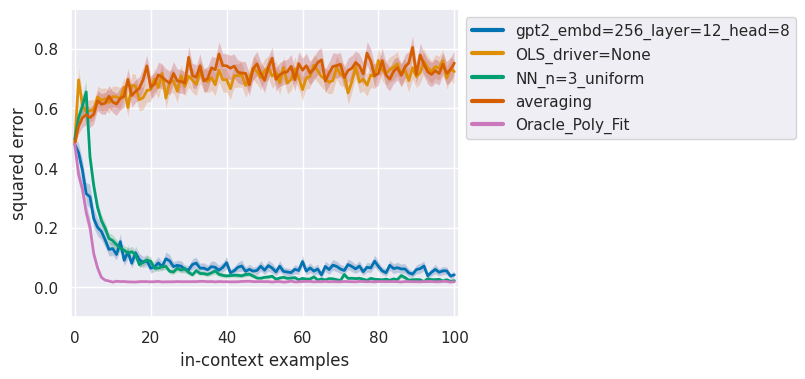

gpt2_embd=256_layer=12_head=8: {'mean': [0.47907742857933044, 0.451242059469223, 0.39379385113716125, 0.314184308052063, 0.30358457565307617, 0.2304048091173172, 0.2010352611541748, 0.1877230554819107, 0.15949910879135132, 0.12730303406715393, 0.13019371032714844, 0.11034408956766129, 0.1534290760755539, 0.09066671133041382, 0.11838147789239883, 0.08100114017724991, 0.11612588167190552, 0.09286127239465714, 0.0840936005115509, 0.08954504877328873, 0.06424707174301147, 0.06887540221214294, 0.08199629932641983, 0.06992491334676743, 0.09589189291000366, 0.0889156386256218, 0.0697333961725235, 0.07386849820613861, 0.07119938731193542, 0.06092507764697075, 0.058525532484054565, 0.07691560685634613, 0.08154868334531784, 0.06436343491077423, 0.06454728543758392, 0.05902519077062607, 0.06956735253334045, 0.06726016104221344, 0.05747281387448311, 0.06721633672714233, 0.08274604380130768, 0.04905100166797638, 0.05559192970395088, 0.067779041826725, 0.07157431542873383, 0.05397985130548477, 0.060

In [5]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

# metrics = collect_results(run_dir, df, valid_row=valid_row)
metrics = get_run_metrics(run_path, cache=False, skip_baselines=False)

_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

# models = relevant_model_names[task]
models = list(metrics["standard"].keys())

print(metrics["standard"].keys())

# basic_plot(metrics["standard"], models=models)
large_plot(metrics["standard"], models=models)
plt.show()

for model in models:
    if model in metrics["standard"]:
        loss_tensor = metrics["standard"][model]
        print(f"{model}: {loss_tensor}")
    else:
        print(f"{model}: not found in metrics")


In [6]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [7]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [8]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [9]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
#ys = task.evaluate(xs,mode="train")

In [10]:
print(xs[0][0])

tensor([-0.0643])


In [11]:
print(ys[0][0])

tensor(-0.1263)


In [12]:
with torch.no_grad():
    pred = model(xs, ys)

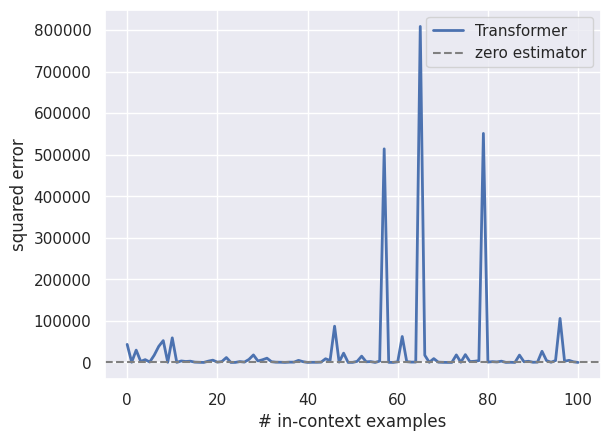

In [13]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "polynomial_regression":125,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [14]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
#ys2 = task.evaluate(xs2, mode="train")
with torch.no_grad():
    pred2 = model(xs2, ys2)

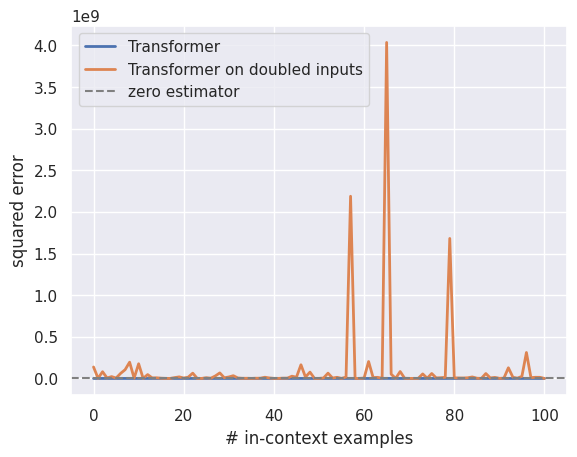

In [15]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

In [16]:
with torch.no_grad():
    # 获取模型中参数所在的设备
    device = next(model.parameters()).device

    # 构造输入为全 0 的向量
    zero_xs = torch.zeros_like(xs).to(device)
    ys_on_device = torch.ones_like(ys).to(device)

    pred_zero = model(zero_xs, ys_on_device)

    print("模型在输入为 0 时的预测结果：")
    print(pred_zero.cpu())
    print(ys_on_device.cpu())
    print(zero_xs)


模型在输入为 0 时的预测结果：
tensor([[-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950],
        [-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950],
        [-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950],
        ...,
        [-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950],
        [-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950],
        [-0.0551,  0.9179,  0.9335,  ...,  0.9046,  0.9032,  0.8950]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         